In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [53]:
def run_RL_carrabin(sid, trial, alpha, n_neurons=50, a=5e-5):
    s = [alpha,alpha,alpha,alpha,alpha]
    seed_net = sid + 1000*trial
    columns = ['type', 'sid', 'trial', 'stage', 'alpha', 'measured alpha']
    dfs = []
    env = Environment(dataset='carrabin', sid=sid, trial=trial, decay='stages', s=s)
    net, sim = simulate_RL(env=env, n_neurons=n_neurons, seed_net=seed_net, z=0, a=a, progress_bar=False)
    for stage in env.stages:
        told = int(((stage-1)*env.T)/env.dt)+2
        tnew = int((stage*env.T)/env.dt)-2
        eold = sim.data[net.probe_prediction][told][0]
        enew = sim.data[net.probe_prediction][tnew][0]
        delta_E = np.abs(enew - eold)
        color = env.empirical.query("stage==@stage")['color'].unique()[0]
        PE = np.abs(color - eold)
        measured_alpha = delta_E / PE
        # print(stage, color, eold, enew, PE, measured_alpha) 
        df = pd.DataFrame([['NEF_RL', sid, trial, stage, alpha, measured_alpha]], columns=columns)
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    return data

In [21]:
empirical = pd.read_pickle(f"data/carrabin.pkl")
sids = empirical['sid'].unique()[:1]
trials = empirical['trial'].unique()[:30]
alpha = 0.17
a = 6e-5

start = time.time()
dfs = []
for sid in sids:
    for trial in trials:
        print(f"sid {sid}, trial {trial}")
        dfs.append(run_RL_carrabin(sid, trial, alpha=alpha, a=a))
alpha_data = pd.concat(dfs, ignore_index=True)
end = time.time()
print(f"runtime {(end-start)/60:.4} min")

sid 1, trial 1
sid 1, trial 2
sid 1, trial 3
sid 1, trial 4
sid 1, trial 5
sid 1, trial 6
sid 1, trial 7
sid 1, trial 8
sid 1, trial 9
sid 1, trial 10
sid 1, trial 11
sid 1, trial 12
sid 1, trial 13
sid 1, trial 14
sid 1, trial 15
sid 1, trial 16
sid 1, trial 17
sid 1, trial 18
sid 1, trial 19
sid 1, trial 20
sid 1, trial 21
sid 1, trial 22
sid 1, trial 23
sid 1, trial 24
sid 1, trial 25
sid 1, trial 26
sid 1, trial 27
sid 1, trial 28
sid 1, trial 29
sid 1, trial 30
runtime 0.4488 min


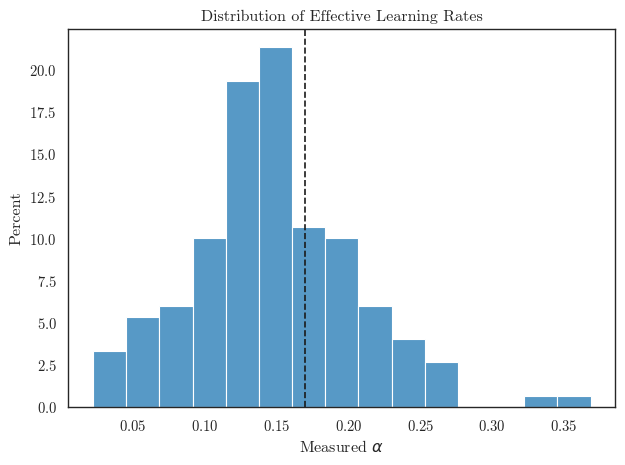

In [22]:
fig, ax = plt.subplots()
sns.histplot(alpha_data, x='measured alpha', color=palette[0], stat='percent')
ax.axvline(alpha, color='k', ls="--")
ax.set(xlabel=r"Measured $\alpha$", title='Distribution of Effective Learning Rates')
plt.tight_layout()
plt.show()
# fig.savefig("data/variance_learning_rate.jpg", dpi=600)

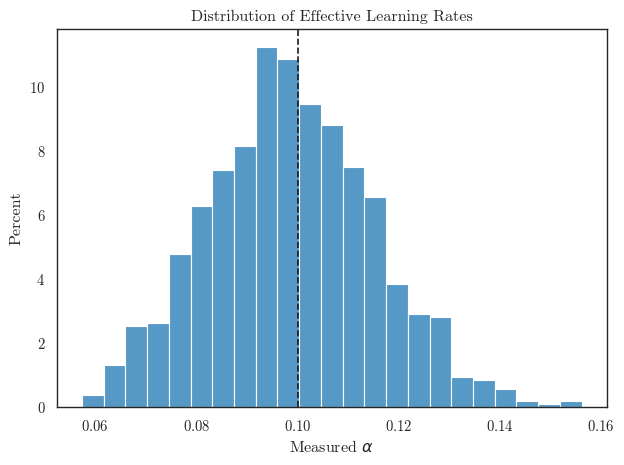

In [33]:
fig, ax = plt.subplots()
sns.histplot(alpha_data, x='measured alpha', color=palette[0], stat='percent')
ax.axvline(alpha, color='k', ls="--")
ax.set(xlabel=r"Measured $\alpha$", title='Distribution of Effective Learning Rates')
plt.tight_layout()
plt.show()
# fig.savefig("plots/variance_learning_rate.jpg", dpi=600)

In [37]:
pd.read_pickle("data/RL_jan27_params.pkl")['alpha'].max()

0.32703222156369044

# Load and Plot

In [23]:
alpha_data = pd.read_pickle("data/NEF_RL_variance_LR_carrabin_alpha_jan31.pkl")

In [24]:
alpha_data

,type,n_neurons,sid,trial,stage,alpha,measured alpha
0,NEF_RL,50,1,1,1,0.168512,0.130292
1,NEF_RL,50,1,1,2,0.168512,0.126840
2,NEF_RL,50,1,1,3,0.168512,0.067225
3,NEF_RL,50,1,1,4,0.168512,0.032798
4,NEF_RL,50,1,1,5,0.168512,0.060858
...,...,...,...,...,...,...,...
4995,NEF_RL,500,1,200,1,0.168512,0.181798
4996,NEF_RL,500,1,200,2,0.168512,0.192596
4997,NEF_RL,500,1,200,3,0.168512,0.190859
4998,NEF_RL,500,1,200,4,0.168512,0.192883


/tmp/ipykernel_102818/3071588252.py:13: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.kdeplot(alpha_data, x='measured alpha', hue='Neurons', palette=palette, common_norm=False, fill=True)


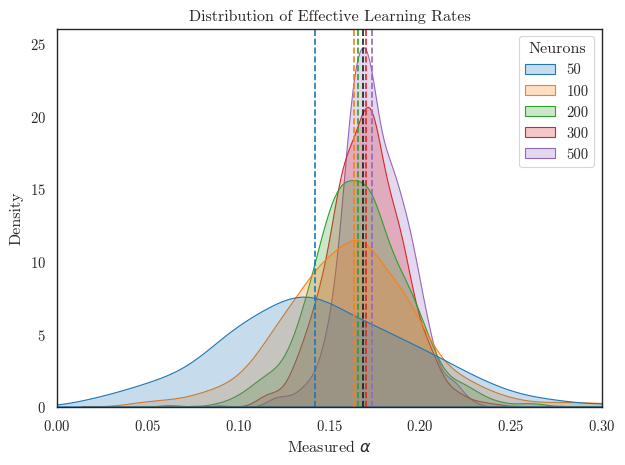

In [48]:
alpha_target = alpha_data['alpha'].unique()[0]
alpha_data = alpha_data.rename(columns={'n_neurons': 'Neurons'})

alpha_measured = alpha_data['measured alpha'].unique()
alpha_bins = np.linspace(0.00, 0.35, 25)
# alpha_bins = np.linspace(np.min(alpha_measured), np.max(alpha_measured), 10)
# alpha_bins = np.linspace(np.min(alpha_measured), 3*np.min(alpha_measured), 10)
# print(alpha_bins)

fig, ax = plt.subplots()
# sns.histplot(alpha_data, x='measured alpha', hue='n_neurons', palette=palette, stat='percent',
#              bins=alpha_bins, element='step')
sns.kdeplot(alpha_data, x='measured alpha', hue='Neurons', palette=palette, common_norm=False, fill=True)
ax.axvline(alpha_target, color='k', ls="--")
for n, neurons in enumerate(alpha_data['Neurons'].unique()):
    median = alpha_data.query("Neurons==@neurons")['measured alpha'].median()
    ax.axvline(median, color=palette[n], ls="--")
ax.set(xlabel=r"Measured $\alpha$", title='Distribution of Effective Learning Rates', xlim=[0, 0.3])
plt.tight_layout()
plt.show()
fig.savefig("plots/variance_learning_rate.jpg", dpi=600)

## Excursions vs Neurons

In [49]:
def array_to_binary(arr):
    arr = (arr == 1).astype(int)
    binary_str = ''.join(arr.astype(str))
    return binary_str

In [65]:
dfs = []
columns = ['type', 'sid', 'qid', 'neurons', 'mean estimate']
# neurons_data = pd.read_pickle("data/NEF_RL_variance_LR_carrabin_alpha_feb3.pkl")
neurons_data1 = pd.read_pickle("data/NEF_RL_variance_LR_carrabin_1_10.pkl")
neurons_data2 = pd.read_pickle("data/NEF_RL_variance_LR_carrabin_1_100.pkl")
neurons_data = pd.concat([neurons_data1, neurons_data2])
empirical = pd.read_pickle(f"data/carrabin.pkl")
sid = 1

for neurons in neurons_data['n_neurons'].unique():
    print(neurons, 'neurons')
    seq_dict = {}
    for stage in range(1, 6):
        sequences = np.array(list(itertools.product([1,-1], repeat=stage)))
        for seq in sequences:
            qid = array_to_binary(seq)
            seq_dict[qid] = []
    for trial in neurons_data.query("n_neurons==@neurons")['trial'].unique():
        for stage in neurons_data.query("n_neurons==@neurons & trial==@trial")['stage'].unique():
            sequence = empirical.query("sid==@sid & trial==@trial & stage<=@stage")['color'].to_numpy()
            estimate = neurons_data.query("n_neurons==@neurons & trial==@trial & stage==@stage")['expectation'].to_numpy()[0]
            qid = array_to_binary(sequence)
            seq_dict[qid].append(estimate)
            # print(sid, trial, stage, sequence, qid)
    for qid, seq in seq_dict.items():
        if len(seq)>0:
            dfs.append(pd.DataFrame([["NEF_RL", sid, qid, neurons, np.mean(seq)]], columns=columns))
avg_estimates = pd.concat(dfs, ignore_index=True)
# avg_estimates.to_pickle("data/avg_estimates.pkl")

10 neurons
100 neurons


In [66]:
dfs = []
columns = ['type', 'sid', 'qid', 'stage', 'neurons', 'excursion']
for neurons in avg_estimates['neurons'].unique():
    print(neurons, 'neurons')
    for trial in neurons_data.query("n_neurons==@neurons")['trial'].unique():
        for stage in neurons_data.query("n_neurons==@neurons & trial==@trial")['stage'].unique():
            sequence = empirical.query("sid==@sid & trial==@trial & stage<=@stage")['color'].to_numpy()
            estimate = neurons_data.query("n_neurons==@neurons & trial==@trial & stage==@stage")['expectation'].to_numpy()[0]
            qid = array_to_binary(sequence)
            avg_est = avg_estimates.query("sid==@sid & qid==@qid & neurons==@neurons")['mean estimate'].unique()[0]
            excursion = np.around(estimate - avg_est, 4)
            dfs.append(pd.DataFrame([["NEF_RL", sid, qid, stage, neurons, excursion]], columns=columns))
excursions = pd.concat(dfs, ignore_index=True)
# excursions.to_pickle("data/excursions.pkl")

10 neurons
100 neurons


/tmp/ipykernel_102818/2153724526.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(excursions, x='excursion', hue='neurons', palette=palette, common_norm=False, fill=True)


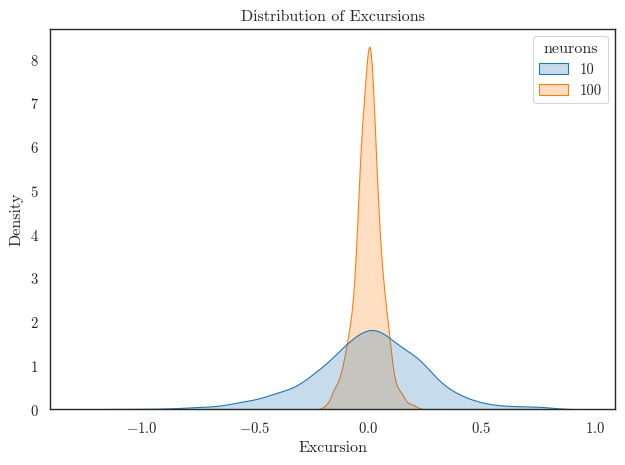

In [67]:
fig, ax = plt.subplots()
sns.kdeplot(excursions, x='excursion', hue='neurons', palette=palette, common_norm=False, fill=True)
ax.set(xlabel="Excursion", title='Distribution of Excursions')
plt.tight_layout()
plt.show()
fig.savefig("plots/NEF_RL_excursions_vs_neurons.jpg", dpi=600)